In [78]:
from pharynx_analysis import (pharynx_io as pio, image_processing as ip, experiment, plots)
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from importlib import reload
from skimage import measure, transform
from collections import namedtuple
import pdb
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import scale
import skimage
import logging
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import seaborn as sns
import tqdm


reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')

In [117]:
experiment_dir = "/Users/sean/code/wormAnalysis/data/single_ratio/2019_05_09_gcy8_hsf1_afd_pharynx"
imaging_scheme = "TL/470/410"

reload(experiment);
ex = experiment.PairExperiment(
    experiment_dir=experiment_dir,
    imaging_scheme=imaging_scheme
)

10:31:01 INFO:Starting full pipeline run for /Users/sean/code/wormAnalysis/data/single_ratio/2019_05_09_gcy8_hsf1_afd_pharynx
10:31:01 INFO:Loading Images
10:31:01 INFO:Segmenting pharynxes
10:31:02 INFO:Centering and rotating pharynxes
100%|██████████| 154/154 [00:05<00:00, 28.72it/s]
10:31:09 INFO:Calculating midlines
100%|██████████| 154/154 [00:01<00:00, 151.04it/s]
10:31:10 INFO:Measuring under midlines
100%|██████████| 154/154 [00:02<00:00, 57.64it/s]
10:31:13 INFO:Registering profiles
10:31:24 INFO:Trimming intensity data
10:31:25 INFO:Calculating redox measurements
/Users/sean/.local/share/virtualenvs/worm/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/Users/sean/.local/share/virtualenvs/worm/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
10:31:25 INFO:Finished full pipeline run for /User

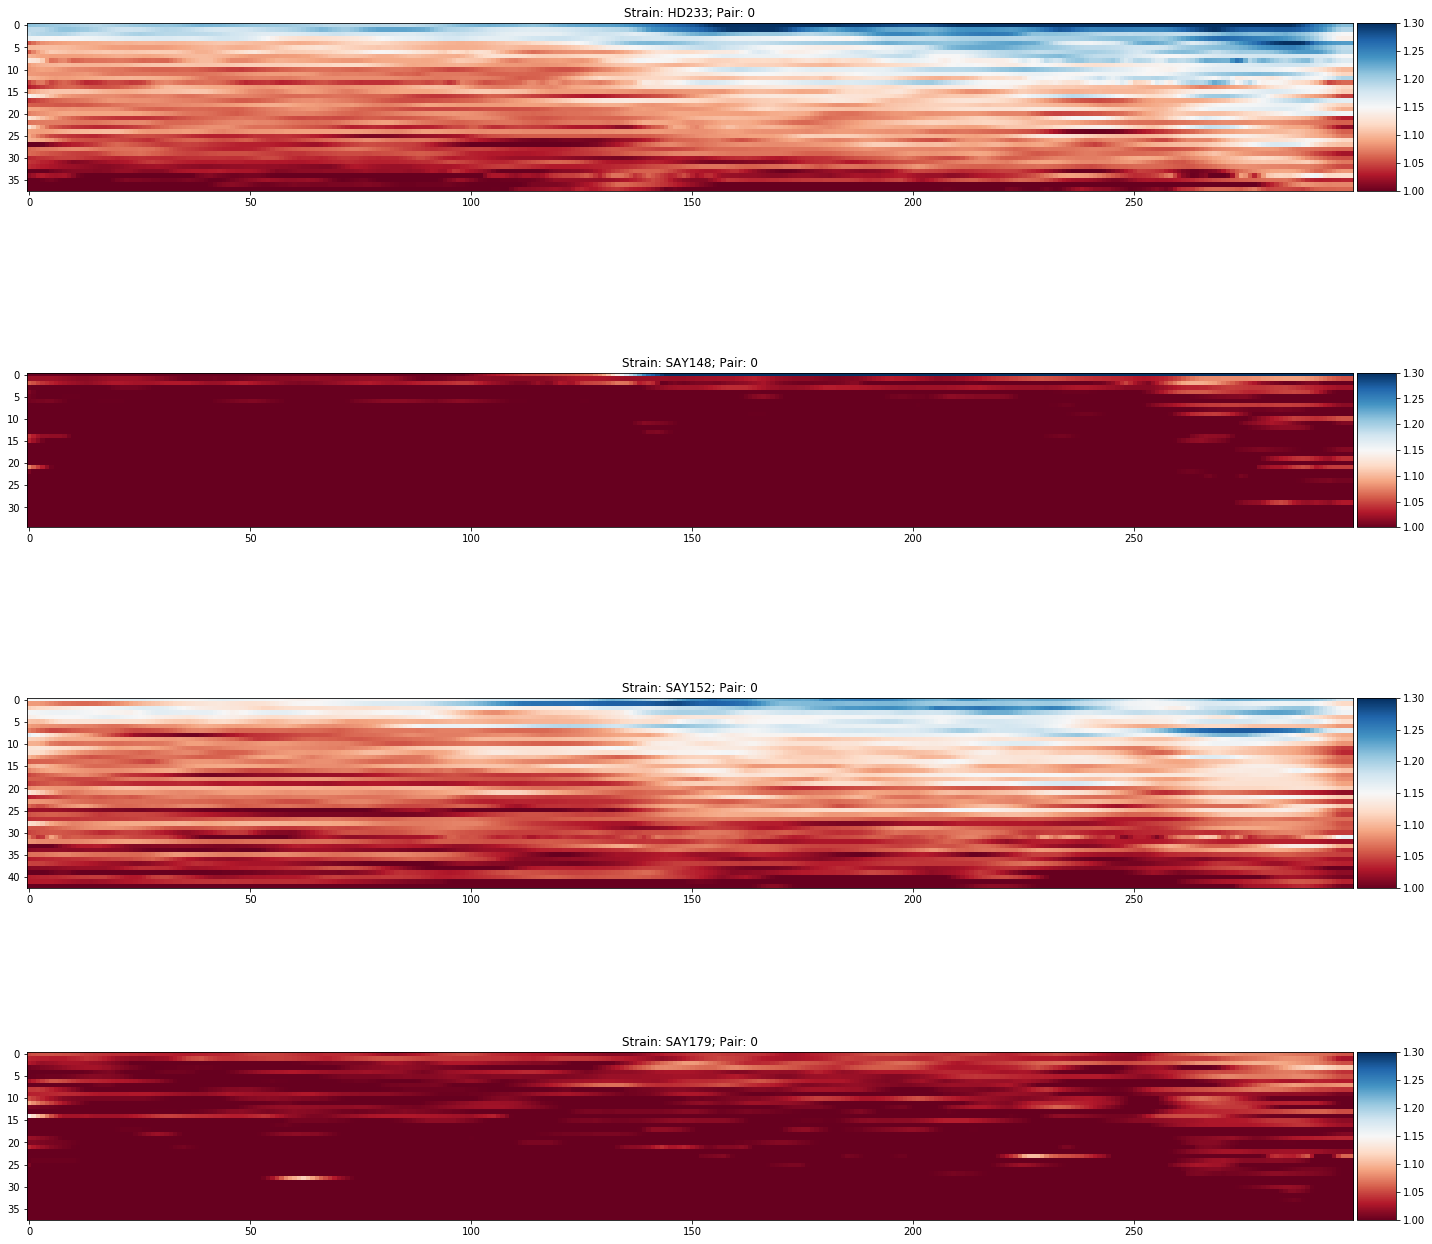

In [83]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

data = ex.trimmed_reg_profiles.sel(wavelength='r')

strains = np.unique(data.strain.data)
n_strains = len(strains)
n_pairs = len(data.pair)
fig, axes = plt.subplots(n_strains, n_pairs, figsize=(20,20))
for strain, ax in zip(strains, axes):
    for i in range(n_pairs):
        subset = data.sel(strain=strain).isel(pair=i)
        sorted_idx = np.flip(np.argsort(subset.mean(dim='position'))).data
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='3%', pad=0.05)

        ax.set_title(f'Strain: {strain}; Pair: {i}')
        im = ax.imshow(subset[sorted_idx], cmap='RdBu')
        im.set_clim([1, 1.3])
        fig.colorbar(im, cax=cax, orientation='vertical')

plt.tight_layout()

In [92]:
dp = pd.read_csv('/Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47/2017_02_22-HD233_SAY47_mvmt_sean.csv')
dp = dp[dp.experiment == '2017_02_22-HD233_SAY47']
dp = dp.pivot_table(index='animal', columns=['region', 'pair'], values='movement')
dp = dp.stack('pair')
dp.head()

FileNotFoundError: [Errno 2] File b'/Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47/2017_02_22-HD233_SAY47_mvmt_sean.csv' does not exist: b'/Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47/2017_02_22-HD233_SAY47_mvmt_sean.csv'

In [114]:
def diagnostic_plot(experiment, i):
    fig = plt.figure(constrained_layout=True, figsize=(15,15))
    gs = GridSpec(2 + experiment.trimmed_reg_profiles.pair.size,3, figure=fig)
    midline_xs = np.arange(40,120)

    ax_i = 0
    for pair in np.arange(ex.raw_image_data.pair.size):
        i410 = ex.rot_fl.sel(wavelength='410', pair=pair).isel(strain=i)
        i470 = ex.rot_fl.sel(wavelength='470', pair=pair).isel(strain=i)
        ax = fig.add_subplot(gs[pair,0])
        ax.imshow(i410)
        ax.plot(midline_xs, ex.midlines[i]['410'][pair](midline_xs), color='orange')
        ax.set_title(f'410-{pair}')

        ax = fig.add_subplot(gs[pair,1])
        ax.imshow(i470)
        ax.plot(midline_xs, ex.midlines[i]['470'][pair](midline_xs), color='r')
        ax.set_title(f'470-{pair}')

        ax = fig.add_subplot(gs[pair,2])
        ax.imshow(i410 / i470)
        ax.plot(midline_xs, ex.midlines[i]['410'][pair](midline_xs), color='orange', label='410', alpha=0.5)
        ax.plot(midline_xs, ex.midlines[i]['470'][pair](midline_xs), color='r', label='470', alpha=0.5)
        ax.set_title(f'(410/470)-{pair}')
        ax.legend()
        ax_i += 1

    ax = fig.add_subplot(gs[ax_i,:])
    for pair in range(ex.raw_image_data.pair.size):
        ax.plot(ex.trimmed_reg_profiles.sel(wavelength='410', pair=pair).isel(strain=i), label=f'410-{pair}')
        ax.plot(ex.trimmed_reg_profiles.sel(wavelength='470', pair=pair).isel(strain=i), label=f'470-{pair}')
    ax.legend()
    ax_i += 1

    
    ax = fig.add_subplot(gs[ax_i:,:])
    for pair in range(ex.raw_image_data.pair.size):
        ax.plot(ex.trimmed_reg_profiles.sel(wavelength='e', pair=pair).isel(strain=i), label=f'E-{pair}')
        ax.set_ylim([np.nanquantile(ex.trimmed_reg_profiles.sel(wavelength='e').data, .01),
                     np.nanquantile(ex.trimmed_reg_profiles.sel(wavelength='e').data, .99)])
    ax.legend()

    plt.suptitle(f'Animal {i} ({ex.strains[i]})')
    
    return fig


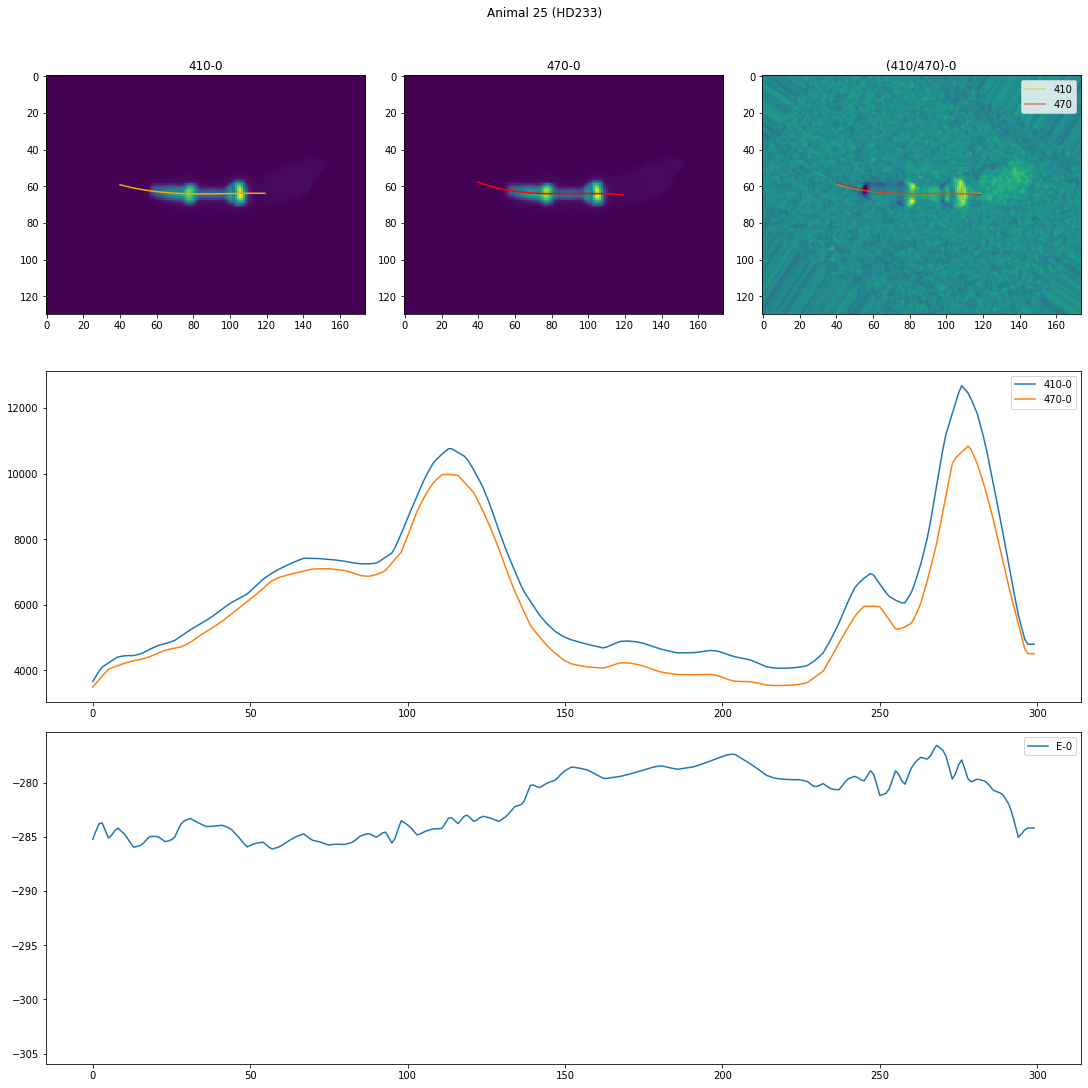

In [115]:
diagnostic_plot(ex, 25);